### データ構造の定義
ヒューマノイドロボットの本と同じくpythonのclassでuLINKの構造を定義する．

下記のデータ構造の例は，「ヒューマノイドロボット」の第２章の例と同じく「name（名前）」，「sister（リンクの兄弟（姉妹））」，「child（リンク子供）」，「m（リンクの質量）」の他に，「mother（リンクの親）」を加えている．


In [1]:
class uLINK:
  def __init__(self, name, sister, child, m, mother):
    self.name = name
    self.sister = sister
    self.child = child
    self.m = m
    self.mother = mother

上記のクラスを使ってリスト構造にデータを代入する．

初期化では，２分木の構造の兄弟（姉妹）と子供のリンク構造だけ与えておき，リンクの親についてはゼロを代入している．

親リンクについては，後にあるFindmotherの関数で自動的に代入されるようになっている．

In [2]:
arr=[0]*10 #10個のリストをゼロで初期化
arr[0]=uLINK("empty",0,0,0,0) #uLINKクラスの定義に沿ってデータを代入
arr[1]=uLINK("BODY",0,2,10,0)
arr[2]=uLINK("RARM",4,3,5,0)
arr[3]=uLINK("RHAND",0,0,1,0)
arr[4]=uLINK("LARM",6,5,5,0)
arr[5]=uLINK("LHAND",0,0,1,0)
arr[6]=uLINK("RLEG",8,7,6,0)
arr[7]=uLINK("RFOOT",0,0,2,0)
arr[8]=uLINK("LLEG",0,9,6,0)
arr[9]=uLINK("LFOOT",0,0,2,0)

### FindMther関数

兄弟と子供のリンク構造を定義しておけば，この関数を使うことで，リンクの親の情報を求めることができる．

In [3]:
def FindMother(j):
    if j != 0:
        if j == 1:
            arr[j].mother = 0;
        if arr[j].child != 0:
            arr[arr[j].child].mother = j;
            FindMother(arr[j].child);
        if arr[j].sister != 0:
            arr[arr[j].sister].mother = arr[j].mother;
            FindMother(arr[j].sister);

下記は，FindMother関数の実行例

FindMother関数の引数に与えたリンク番号の下に位置している兄弟リンクと子供リンクのすべての親のIDをリンク構造の定義motherに代入してくれる．

In [4]:
FindMother(1) #ID1以下のリンクの親のIDを登録
print("arr[8].mother: ", arr[8].mother) #リンク8の親のIDを表示

arr[8].mother:  1


### TotalMass関数

引数に与えたリンク番号以下のリンク構造すべての質量の和を計算する．

In [5]:
def TotalMass(x):
  if x == 0:
    m = 0
    return m
  else:
    m = arr[x].m + TotalMass(arr[x].sister) + TotalMass(arr[x].child)
    return m

In [6]:
TotalMass(1) #リンク１以下のすべての質量の和．

38

### PrintLinkName関数

引数に与えたリンク番号以下のリンク番号と名前を表示する関数．

In [7]:
def PrintLinkName(j):
    if j != 0:
        print('ID=', j, arr[j].name)
        PrintLinkName(arr[j].child);
        PrintLinkName(arr[j].sister);
    

In [8]:
PrintLinkName(1) #リンク１以下のすべてのリンク番号と名前を表示

ID= 1 BODY
ID= 2 RARM
ID= 3 RHAND
ID= 4 LARM
ID= 5 LHAND
ID= 6 RLEG
ID= 7 RFOOT
ID= 8 LLEG
ID= 9 LFOOT


### Rodriges関数

ロドリゲスの式を使った回転行列の計算を行うための関数．
入力は，第１引数に回転ベクトル（回転軸を表す単位ベクトル），第２引数に回転軸周りに回転した角度を与えることで，回転行列を得ることができる．

In [9]:
def Rodrigues(w,dt):
    norm_w = np.linalg.norm(w);
    if norm_w < sys.float_info.epsilon :
        R = np.eye(3);
    else :
        th = norm_w * dt;
        wn = w/norm_w;
        w_wedge = np.array([ [0, -wn[2], wn[1]],[wn[2], 0, -wn[0]],[-wn[1], wn[0], 0]]);
        R = np.eye(3) + w_wedge * math.sin(th) + np.matmul(w_wedge,w_wedge) * (1-math.cos(th));
    return R

In [10]:
#Rodrigues関数の利用例
import numpy as np #行列計算のためnumpyをインポート
import math        #三角関数を使うためにmathをインポート
import sys         #計算機イプシロンを使うためにsysをインポート
w=[1.0, 0.0, 0.0]; #回転ベクトルを定義：x軸回りの回転を表す
dt=0.5;            #回転ベクトル周りの回転量(rad)を与える
Rodrigues(w,dt)    #回転行列R(3x3行列)を計算

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.87758256, -0.47942554],
       [ 0.        ,  0.47942554,  0.87758256]])

### ForwardKinematics関数

順運動学の計算を行う関数．引数を与えたリンク以下のすべてのリンクの関節位置を現在の関節角度から計算する．再帰関数を利用しているため非常にシンプルにすべての関節の位置と姿勢（回転行列）を得ることができる．

In [11]:
def ForwardKinematics(j):
    if j == 0: return
    if j != 1:
        mom = arr[j].mother;
        arr[j].p = np.matmul(arr[mom].R, arr[j].b) + arr[mom].p
        ROD = Rodrigues(arr[j].a, arr[j].q);
        arr[j].R = np.matmul(arr[mom].R, ROD);
    ForwardKinematics(arr[j].sister);
    ForwardKinematics(arr[j].child);

### データ構造の定義の追加

一番初めに定義した「name（名前）」，「sister（リンクの兄弟（姉妹））」，「child（リンク子供）」，「m（リンクの質量）」の他に，「mother（リンクの親）」の他に，順運動学計算に必要となるリンク間距離(b：３次元ベクトル)や関節の回転軸(a：３次元ベクトル)，関節の回転角(q：スカラ)，リンクの回転行列(R：絶対座標基準)，リンクの位置(p：絶対座標基準)を追加している．

In [12]:
class uLINK:
  def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p):
    self.name = name
    self.sister = sister
    self.child = child
    self.mother = mother
    self.m = m
    self.b = b
    self.a = a
    self.q = q
    self.R = R
    self.p = p

新しく設定した定義似合わせて，リンクの情報を下記の例の通り設定している．

右足(RLEG）と左足（LLEG）はそれぞれJ0からJ5の６つの関節を有しているロボットアーム（レッグ）となっている．

股関節（肩関節）に３軸直交（J0のZ軸回転（ヨー）とJ1のX軸回転（ロール），J2のY軸回転（ピッチ）が同じ位置に設定されている）となっており，膝関節はJ3関節にY軸回り（ピッチ）の関節，足首には，J4関節にY軸（ヨー）とJ5関節にX軸（ロール）の関節を与えている．


In [13]:
ToDeg = 180/math.pi;   #r adianからdegreeに変換するときの係数
ToRad = math.pi/180;   #d egreeからradianに変換するときの係数

UX = [1.0,0.0,0.0];    # X軸の単位ベクトルで関節軸を設定するためのシンボル設定
UY = [0.0,1.0,0.0];    # Y軸の単位ベクトルで関節軸を設定するためのシンボル設定
UZ = [0.0,0.0,1.0];    # Z軸の単位ベクトルで関節軸を設定するためのシンボル設定

R0=np.eye(3);          # 単位行列のシンボル設定
p0= [0,0,0];           # ゼロ位置のシンボル設定

arr = [0]*14          # リンクの数（この例では14リンク）の配列を初期化

arr[0]=uLINK("empty",0,0,0,0,0,0,0,R0,p0) # 空のゼロリンクを設定（ワールド座標系）
arr[1]=uLINK("BODY", 0, 2, 0, 10, [0.0, 0.0, 0.7],UZ,0,R0,p0) # Bodyのリンク初期化

# 右足のリンクの初期化：第3関節（股関節のピッチ）と第4関節（膝関節）のピッチ角を与えている）
arr[2]=uLINK("RLEG_J0", 8, 3, 0, 5, [0.0,-0.1, 0.0],UZ,0,R0,p0)
arr[3]=uLINK("RLEG_J1", 0, 4, 0, 1, [0.0, 0.0, 0.0],UX,0,R0,p0)
arr[4]=uLINK("RLEG_J2", 0, 5, 0, 5, [0.0, 0.0, 0.0],UY,-90*ToRad,R0,p0)
arr[5]=uLINK("RLEG_J3", 0, 6, 0, 1, [0.0, 0.0,-0.3],UY,90*ToRad,R0,p0)
arr[6]=uLINK("RLEG_J4", 0, 7, 0, 6, [0.0, 0.0,-0.3],UY,0,R0,p0)
arr[7]=uLINK("RLEG_J5", 0, 0, 0, 2, [0.0, 0.0, 0.0],UX,0,R0,p0)

# 左足のリンクの初期化：第10関節（股関節のピッチ）と第11関節（膝関節）のピッチ角を与えている）
arr[8] =uLINK("LLEG_J0", 0,  9, 0, 5, [0.0, 0.1, 0.0],UZ,0,R0,p0)
arr[9] =uLINK("LLEG_J1", 0, 10, 0, 1, [0.0, 0.0, 0.0],UX,0,R0,p0)
arr[10]=uLINK("LLEG_J2", 0, 11, 0, 5, [0.0, 0.0, 0.0],UY,-90*ToRad,R0,p0)
arr[11]=uLINK("LLEG_J3", 0, 12, 0, 1, [0.0, 0.0,-0.3],UY,90*ToRad,R0,p0)
arr[12]=uLINK("LLEG_J4", 0, 13, 0, 6, [0.0, 0.0,-0.3],UY,0,R0,p0)
arr[13]=uLINK("LLEG_J5", 0,  0, 0, 2, [0.0, 0.0, 0.0],UX,0,R0,p0)

FindMother(1)

上記の様に各リンクの設定が適切に行われていれば，ForwardKinematics関数を呼び出すだけで，各関節の位置と姿勢を求めることができる．

下記に使用例を示す．

In [14]:
ForwardKinematics(1) #第１リンク以下のすべてのリンク位置と姿勢を計算
print(arr[7].p)      #第７リンクの関節位置を表示（右足首の位置）
print(arr[7].R)      #第７リンクの関節の姿勢行列を表示（右足首の姿勢行列）
print(arr[13].p)     #第13リンクの関節位置を表示（左足首の位置）
print(arr[13].R)     #第13リンクの関節の姿勢行列を表示（左足首の姿勢行列）

[ 0.3 -0.1 -0.3]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[ 0.3  0.1 -0.3]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


イメージがつきやすいように下記のコードで，3次元のグラフに各関節の位置をプロットして線でつなげた図を示す．

「#inline」をつけることで，プロット図をjupyternotebook上でも見ることができる．

下記では記載していないが「%matplotlib notebook」と記載をしておくと，3次元プロットをドラッグして別の視点からも見ることができる．

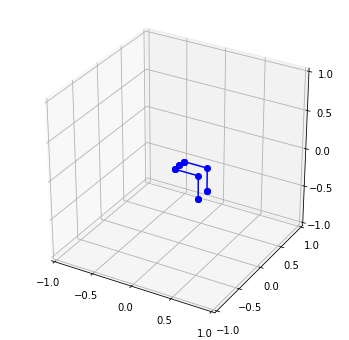

In [19]:
#inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])

ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b')
ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b')
ax.set_xticks(np.linspace(-1.0, 1.0, 5))
ax.set_yticks(np.linspace(-1.0, 1.0, 5))
ax.set_zticks(np.linspace(-1.0, 1.0, 5))

plt.show()

## RPY2R関数

roll(X軸回りの回転角），pitch(Y軸回りの回転角），yaw(Z軸回りの回転角）の角度から回転行列R（３ｘ３）を求める関数．


In [16]:
def RPY2R(rpy):
    roll = rpy[0]; pitch = rpy[1]; yaw = rpy[2];
    Cphi = math.cos(roll);  Sphi = math.sin(roll);
    Cthe = math.cos(pitch); Sthe = math.sin(pitch);
    Cpsi = math.cos(yaw);   Spsi = math.sin(yaw);

    R = [[Cpsi*Cthe,  -Spsi*Cphi+Cpsi*Sthe*Sphi,  Spsi*Sphi+Cpsi*Sthe*Cphi],
       [Spsi*Cthe,  Cpsi*Cphi+Spsi*Sthe*Sphi,   -Cpsi*Sphi+Spsi*Sthe*Cphi],
       [-Sthe,      Cthe*Sphi,                  Cthe*Cphi]                 ]
    return R


## FindRoute関数

求めたい位置・姿勢のリンクを引数に与えると，Bodyリンクからのリンクのつながり（ルート）を配列で返してくれる．

例えば，引数に右足首の最終関節のリンク番号7を与えるとボディリンク１からどの関節を経由してリンク７につながっているか配列で返してくれる．<br>
FindRoute(7)　と入力すると<br>
[2,3,4,5,6,7]　という配列が返ってくる

In [17]:
def FindRoute(to):
#return the list of joint number connecting ROOT to 'to'
    i = arr[to].mother;
#if i == 0
#    idx = [];    % search failed
#    fprintf('FindRoute: search failed\n');
#else
    if i == 1:
        idx = [to];
    else:
        idx = FindRoute(i) + [to];
    return idx


In [18]:
FindRoute(7)

[2, 3, 4, 5, 6, 7]

In [ ]:
def rot2omega(R):
    # T.Sugihara "Solvability-unconcerned Inverse Kinemacics based on 
    # Levenberg-Marquardt method with Robust Damping," Humanoids 2009
    #el = [R[3,2]-R[2,3], R[1,3]-R[3,1], R[2,1]-R[1,2]];
    el = np.array([R[2,1]-R[1,2], R[0,2]-R[2,0], R[1,0]-R[0,1]]);
    norm_el = np.linalg.norm(el);
    if norm_el >  sys.float_info.epsilon :
        #print("el ",el)
        #print("norm_el ",norm_el)
        #print("np.trace(R)", (np.trace(R)-1))
        #print("atan2 ",math.atan2(norm_el, np.trace(R)-1))
        w = math.atan2(norm_el, np.trace(R)-1)/norm_el * el;
    elif R[0,0]>0 and R[1,1]>0 and R[2,2]>0 :#elif R[1,1]>0 and R[2,2]>0 and R[3,3]>0 :
        w = [0, 0, 0];
    else :
        w = math.pi/2*[R(0,0)+1, R(1,1)+1, R(2,2)+1];#w = math.pi/2*[R(1,1)+1, R(2,2)+1, R(3,3)+1];
    return w

In [ ]:
def CalcVWerr(arr1, arr2):
    perr = arr1.p - arr2.p;
    Rerr = np.matmul(arr2.R.T, arr1.R);
    werr = np.matmul(arr2.R, rot2omega(Rerr));
    #print("rot2omega",rot2omega(Rerr))
    #err = [perr, werr];
    err = [0]*6

    for k in range(3):
        err[k] = perr[k];
        err[k+3] = werr[k];
    return err

In [ ]:
def  CalcJacobian_rot(idx) :
    #Jacobian matrix of current configration in World frame
    jsize = len(idx);
    target = arr[idx[jsize-1]].p;#   % absolute target position
    J = np.zeros(3,jsize);

    for n in range(jsize):
        j = idx[n];
        a = np.matmul(arr[j].R, arr[j].a);#  % joint axis vector in world frame
        np.cross(a, target - arr[j].p);
    return J

In [ ]:
def CalcJacobian(idx) :
    # Jacobian matrix of current configration in World frame
    jsize = len(idx);
    target = arr[idx[jsize-1]].p;   #% absolute target position
    J = np.zeros((6,jsize));
    JT = np.zeros((jsize,6));

    for n in range(jsize) : #n=1:jsize
        j = idx[n];
        #print("j ", j)
        #print("arr.R ", arr[j].R)
        #print("arr.a ", arr[j].a)
        a = np.matmul(arr[j].R, arr[j].a);  #% joint axis vector in world frame
        #print("cross ", np.cross(a, target - arr[j].p) )
        #print("a ", a)
        cross = np.cross(a, target - arr[j].p);
        #print("len(cross) ", len(cross))
        for k in range(len(cross)):
            J[k, n] = cross[k];
            J[k+len(cross),n] = a[k];

    return J



In [ ]:
def InverseKinematics(to, Target):
    lam = 0.9;
    idx = FindRoute(to);
    #print("idx ", idx)
    ForwardKinematics(1);
    err = CalcVWerr(Target, arr[to]);
   # print("err ",err)
    for n in range(10):
        if np.linalg.norm(err) < 1e-6 : break;
        J  = CalcJacobian(idx);
        #print("J ", J )
        dq = lam * np.matmul(np.linalg.inv(J), err);
        print("dq ",dq)
        #print("idx ", idx)
        MoveJoints(idx, dq);
        ForwardKinematics(1);
        err = CalcVWerr(Target, arr[to]);
        #print("err ", err)

    err_norm = np.linalg.norm(err);
    return err_norm

In [ ]:
def MoveJoints(idx, dq):
    for n in range(len(idx)):
        j = idx[n];
        arr0 = arr[j].q
        arr[j].q = arr[j].q + dq[n];
        #print("arr1, arr0, dq ",arr[n].q , arr0 , dq[n])
    #print("arr_q ", arr[0].q, arr[1].q, arr[2].q, arr[3].q, arr[4].q, arr[5].q)

In [ ]:
#ヤコビ行列を使った逆運動学計算
#初期姿勢がおかしいと計算できないことがあるので注意
Rfoot=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0)
Lfoot=uLINK("Lfoot_target",0,0,0,0,0,0,0,R0,p0)
RLEG_J5 = 7;
LLEG_J5 = 13;

Rfoot.p = [0.0, -0.1, -0.3]; # [0, -0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Rfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4
rerr_norm = InverseKinematics(RLEG_J5, Rfoot);

Lfoot.p = [0, 0.1, -0.4]; # [0, 0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Lfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4
lerr_norm = InverseKinematics(LLEG_J5, Lfoot);

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])

ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b')
ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b')
ax.set_xticks(np.linspace(-1.0, 1.0, 5))
ax.set_yticks(np.linspace(-1.0, 1.0, 5))
ax.set_zticks(np.linspace(-1.0, 1.0, 5))
#inline
plt.show()
print("arr[7].p ", arr[7].p)
print("rerr_norm ", rerr_norm)
print("arr[13].p ", arr[13].p)
print("lerr_norm ", lerr_norm)

In [ ]:
def Draw_R(arr):
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
    r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
    l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])

    ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b')
    ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b')
    ax.set_xticks(np.linspace(-1.0, 1.0, 5))
    ax.set_yticks(np.linspace(-1.0, 1.0, 5))
    ax.set_zticks(np.linspace(-1.0, 1.0, 5))
    #inline
    plt.show()

In [ ]:
Draw_R(arr)

In [ ]:
def SetJointAngles(idx, q):
    for n in range(len(idx)):
        j = idx[n];
        arr[j].q = q[n];
        
    ForwardKinematics(1);

In [ ]:
def InverseKinematics_LM(to, Target):
# Levenberg-Marquardt, Chan-Lawrence, Sugihara's modification

    idx = FindRoute(to);
    wn_pos = 1/0.3;
    wn_ang = 1/(2*math.pi);
    We = np.diag([wn_pos, wn_pos, wn_pos, wn_ang, wn_ang, wn_ang]);#何やってる？
    Wn = np.eye(len(idx));#何やってるの？

    ForwardKinematics(1);
    err = CalcVWerr(Target, arr[to]);
    Ek = np.matmul(np.matmul(err, We),err); #Ek = err'*We*err;

    for n in range(10):
        J  = CalcJacobian(idx);
        #Jh = J'*We*J + Wn*(Ek + 0.002);  %Hk + wn
        Jh = np.matmul(np.matmul(J.T,We),J) + Wn*(Ek+0.002)
        #gerr = J'*We*err;    %gk
        gerr = np.matmul(np.matmul(J.T, We), err);
        #dq   = Jh \ gerr;    %new
        dq = np.matmul(np.linalg.inv(Jh), gerr);
            
        MoveJoints(idx, dq);
        ForwardKinematics(1);
        err = CalcVWerr(Target, arr[to]);
        Ek2 = np.matmul(np.matmul(err, We),err);
        #print("Ek2 ",Ek2)
        #Ek2 = err'*We*err;
        if Ek2 < 1e-12:
          break;
        elif Ek2 < Ek:
          Ek = Ek2;
        else:
          MoveJoints(idx, -dq);#  % revert
          ForwardKinematics(1);
        break; 
        #end
    #end

    #if nargout == 1 
    err_norm = np.linalg.norm(err);
    #end

    return err_norm

In [ ]:
# Numerical inverse kinematics and knee stretch
# ik_stretch_LM.m
# 2013 Sept.23 s.kajita AIST

SkipFrame = 10;#描画のスキップ

RLEG_J0 = 2;
RLEG_J5 = 7;
LLEG_J5 = 13;

#%%%%%%%%%%% target foot position and orientation %%%%%%%%%%%%
idx   = FindRoute(RLEG_J5);

target = np.array([0.0, 0.0, -25.0, 50.0, -25.0, 0.0])#deg
SetJointAngles(idx, target*ToRad);

Rfoot=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0)
#Lfoot=uLINK("Lfoot_target",0,0,0,0,0,0,0,R0,p0)
Rfoot.p = [0.0, -0.1, -0.4]; # [0, -0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Rfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4

#Lfoot.p = [0, 0.1, -0.4]; # [0, 0.1, 0] + 0.2*(np.random.rand(3)-0.5);
#Lfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4


Height = np.linalg.norm(arr[RLEG_J0].p - arr[RLEG_J5].p);
LegLength = 0.6;
SingularPoint = math.sqrt(0.6*0.6 - Height*Height);

#ここからまだ修正していない
#xd_m = 0:0.005:0.4';
Nstep = 150 #length(xd_m);
#q_m = zeros(Nstep,6);
#analy_q_m = zeros(Nstep,6);
#x_m = zeros(Nstep,1);
#manip_m = zeros(Nstep,1);

print("Rfoot ", Rfoot.p[0] );

for n in range(Nstep):
    Rfoot.p[0] = 0.0 + 0.005 * n;  #右足のxを更新　% Right foot

    #print("Rfoot ", Rfoot.p[0] );
    #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])

    rerr_norm = InverseKinematics_LM(RLEG_J5, Rfoot);
    
    #print("arr_p[0] ", arr[RLEG_J5].p[0]);
    #q_m(n,:) = [uLINK(idx).q];
    #analy_q_m(n,:) = IK_leg(uLINK(BODY),-0.1,0.3,0.3,Rfoot)';      %%% Analytical inverse kinematics solution

    #J = CalcJacobian(idx);
    #manip_m(n) = abs(det(J));
    
    if np.mod(n,SkipFrame) == 1:
        #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])
        Draw_R(arr);
        print("Error ", rerr_norm);





In [ ]:
# ik_strechのgifアニメーションセーブバージョン

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

SkipFrame = 10;#描画のスキップ

RLEG_J0 = 2;
RLEG_J5 = 7;
LLEG_J5 = 13;

#%%%%%%%%%%% target foot position and orientation %%%%%%%%%%%%
idx   = FindRoute(RLEG_J5);

target = np.array([0.0, 0.0, -25.0, 50.0, -25.0, 0.0])#deg
SetJointAngles(idx, target*ToRad);

Rfoot=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0)
#Lfoot=uLINK("Lfoot_target",0,0,0,0,0,0,0,R0,p0)
Rfoot.p = [0.0, -0.1, -0.4]; # [0, -0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Rfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4

#Lfoot.p = [0, 0.1, -0.4]; # [0, 0.1, 0] + 0.2*(np.random.rand(3)-0.5);
#Lfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4


Height = np.linalg.norm(arr[RLEG_J0].p - arr[RLEG_J5].p);
LegLength = 0.6;
SingularPoint = math.sqrt(0.6*0.6 - Height*Height);


#xd_m = 0:0.005:0.4';
Nstep = 100 #length(xd_m);
#q_m = zeros(Nstep,6);
#analy_q_m = zeros(Nstep,6);
#x_m = zeros(Nstep,1);
#manip_m = zeros(Nstep,1);

print("Rfoot ", Rfoot.p[0] );

data = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})

ims = []

def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])


for n in range(Nstep):
    Rfoot.p[0] = 0.0 + 0.005 * n;  #右足のxを更新　% Right foot

    #print("Rfoot ", Rfoot.p[0] );
    #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])

    rerr_norm = InverseKinematics_LM(RLEG_J5, Rfoot);

    r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
    l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])
    data = np.vstack((data,r_leg));
    
    #print("arr_p[0] ", arr[RLEG_J5].p[0]);
    #q_m(n,:) = [uLINK(idx).q];
    #analy_q_m(n,:) = IK_leg(uLINK(BODY),-0.1,0.3,0.3,Rfoot)';      %%% Analytical inverse kinematics solution

    #J = CalcJacobian(idx);
    #manip_m(n) = abs(det(J));
    
    if np.mod(n,SkipFrame) == 1:
        #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])
        #Draw_R(arr);
        #Gen_R(arr);
        r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
        l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])
        im1, = ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b')
        im2, = ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b')
        ims.append([im1,im2])
        print("Error ", rerr_norm);
        
ax.set_xticks(np.linspace(-1.0, 1.0, 5))
ax.set_yticks(np.linspace(-1.0, 1.0, 5))
ax.set_zticks(np.linspace(-1.0, 1.0, 5))
ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('anim.gif', writer="pillow")
#ani.save('anim.mp4', writer="ffmpeg")
plt.show()

In [ ]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
arr=[0]*10

In [1]:
#For Dynamic simulation
class uLINK:
  def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
    self.name = name
    self.sister = sister
    self.child = child
    self.mother = mother
    self.m = m
    self.b = b
    self.a = a
    self.q = q
    self.R = R
    self.p = p
    self.dq =dq
    self.ddq = ddq
    self.c  = c
    self.I  = I
    self.u  = u
    self.dw = dw

In [ ]:
def MakeRigidBody(j, wdh, mass):
    arr[j].m = mass;
    arr[j].c = [0, 0, 0];
    arr[j].I = np.array([[1/12*(wdh[1]*wdh[1] + wdh[2]*wdh[2]), 0.0, 0.0],
            [0.0, 1/12*(wdh[0]*wdh[0] + wdh[2]*wdh[2]),  0.0],
            [0.0, 0.0, 1/12*(wdh[0]*wdh[0] + wdh[1]*wdh[1])]]) * mass;
    arr[j].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])
    for n in range(3):
        for i in range(8):
            arr[1].vertex[i,n] = arr[1].vertex[i,n] - wdh[n]/2;
        
    arr[j].face = [
        [1, 2, 3, 4], [2, 6, 7, 3], [4, 3, 7, 8],
        [1, 5, 8, 4], [1, 2, 6, 5], [5, 6, 7, 8]
        ];

In [ ]:
def EulerDynamics(j):
    I = np.matmul(np.matmul(arr[j].R, arr[j].I), arr[j].R.T); #    % 慣性テンソル
    L = np.matmul(I, arr[j].w);   #                           % 角運動量
    arr[j].dw  = np.matmul(np.linalg.pinv(I), -np.cross(arr[j].w, L)); #   % Eulerの方程式
    return L

In [114]:
def ShowObject(arr):
    vert = np.matmul(arr[1].R, arr[1].vertex.T);
    for k in range(3) :# 1:3
        vert[k,:] = vert[k,:] + arr[1].p[k];#   % adding x,y,z to all vertex

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
    im=ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
    ax.set_xticks(np.linspace(AX[0], AX[1], 5))
    ax.set_yticks(np.linspace(AY[0], AY[1], 5))
    ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))
    #inline
    plt.show()


In [ ]:
arr = [0]*2
arr[1]=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,0)
lx  = 0.1; ly  = 0.4; lz  = 0.9;
wdh=[lx, ly, lz];
AX=[-0.5, 0.5]; AY=[-0.5, 0.5]; AZ=[-0.5, 1.0];
arr[1].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])
for n in range(3):
    for j in range(8):
        arr[1].vertex[j,n] = arr[1].vertex[j,n] - wdh[n]/2;

print(arr[1].vertex[0,:])
print(arr[1].vertex)
    
ShowObject(arr)

In [ ]:
#rigidbody_rotate.m
lx  = 0.1; ly  = 0.4; lz  = 0.9;
mass = 36.0; 
R0=np.eye(3);
p0= [0,0,0];

arr = [0]*2
arr[1]=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,0)

MakeRigidBody(1, [lx, ly, lz], mass); #直方体のデータを作成

arr[1].p = [0.0, 0.0, 0.0];
arr[1].R = np.eye(3); 
arr[1].w = [1, 1, 1];      #% 初期角速度 [rad/s]
Dtime   = 0.02;
EndTime = 5.0;

time  = 250#EndTime/Dtime;

#figure
AX=[-0.5, 0.5]; AY=[-0.5, 0.5]; AZ=[-0.5, 1.0];

for n in range(time):
    L = EulerDynamics(1);
    arr[1].R = np.matmul(Rodrigues(arr[1].w, Dtime), arr[1].R);
    arr[1].w = arr[1].w + Dtime * arr[1].dw; 
    #print(arr[1].R)
    ShowObject(arr);  

In [ ]:
#rigidbody_rotate.m アニメーション出力
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

ims =[]
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
ax.set_xticks(np.linspace(AX[0], AX[1], 5))
ax.set_yticks(np.linspace(AY[0], AY[1], 5))
ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))

lx  = 0.1; ly  = 0.4; lz  = 0.9;
mass = 36.0; 
R0=np.eye(3);
p0= [0,0,0];

arr = [0]*2
arr[1]=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,0)

MakeRigidBody(1, [lx, ly, lz], mass); #直方体のデータを作成

arr[1].p = [0.0, 0.0, 0.0];
arr[1].R = np.eye(3); 
arr[1].w = [1, 1, 1];      #% 初期角速度 [rad/s]
Dtime   = 0.02;
EndTime = 5.0;

time  = 250#EndTime/Dtime;

#figure
AX=[-0.5, 0.5]; AY=[-0.5, 0.5]; AZ=[-0.5, 1.0];

for n in range(time):
    L = EulerDynamics(1);
    arr[1].R = np.matmul(Rodrigues(arr[1].w, Dtime), arr[1].R);
    arr[1].w = arr[1].w + Dtime * arr[1].dw; 
    #print(arr[1].R)
    
    vert = np.matmul(arr[1].R, arr[1].vertex.T);
    for k in range(3) :# 1:3
        vert[k,:] = vert[k,:] + arr[1].p[k];#   % adding x,y,z to all vertex


    im = ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
    ims.append(im)
    

ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('anim.gif', writer="pillow")
#ani.save('anim.mp4', writer="ffmpeg")
plt.show()
    

In [ ]:
from itertools import combinations
from itertools import product
from itertools import repeat

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

points = product(*repeat((-1, 1), 3))
for p1, p2 in combinations(points, 2):
    if [*map(sum, zip(p1, p2))].count(0) ==1:
       ax.plot3D(*zip(p1, p2), color="b")

plt.show()

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x = [-1,1]
y = [-1,1]
X,Y = np.meshgrid(x,y)
Z = np.array([[1,1],[1,1]])

ax = plt.subplot(111, projection='3d')
ax.plot_surface(X,Y,Z,alpha=0.7)
ax.plot_surface(X,Y,-Z,alpha=0.7)
ax.plot_surface(X,Z,Y,alpha=0.7)
ax.plot_surface(X,-Z,Y,alpha=0.7)
ax.plot_surface(-Z,X,Y,alpha=0.7)
ax.plot_surface(-Z,X,Y,alpha=0.7)
#ax.set_xlim(-2, 2)
#ax.set_ylim(-2, 2)
#ax.set_zlim(-2, 2)
plt.show()

## 順運動学

単位ベクトル法による順運動学の計算．単一剛体の並進と回転の運動をシミュレーションするプログラム．

In [97]:
def DrawAllJoints(j):
    radius    = 0.02;
    len       = 0.06;
    joint_col = 0;

    if j != 0 : 
        #print("arr.vertex ", arr[j].vertex);
        if arr[j].vertex.any() : #vertexが空じゃなかったら．~isempty(uLINK(j).vertex)
            #print("arr.vertex ", arr[j].vertex);
            vert = np.matmul(arr[j].vertex, arr[j].R);
            for k in range(3): # 1:3
                vert[k,:] = vert[k,:] + arr[j].p[k]; #% adding x,y,z to all vertex
            ShowObject(arr) #DrawPolygon(vert, uLINK(j).face,0);
    
        i = arr[j].mother;
        if i != 0:
            #Connect3D(uLINK(i).p,uLINK(j).p,'k',2);
            #function Connect3D(p1,p2,option,pt)
            #h = plot3([p1(1) p2(1)],[p1(2) p2(2)],[p1(3) p2(3)],option);
            #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
            im=ax.plot([arr[i].p[0],arr[j].p[0]],[arr[i].p[1],arr[j].p[1]],[arr[i].p[2],arr[j].p[2]],"o-", c='b')
            #set(h,'LineWidth',pt)
            ims.append(im)

        #DrawCylinder(uLINK(j).p, uLINK(j).R * uLINK(j).a, radius,len, joint_col);
    
    
        DrawAllJoints(arr[j].child);
        DrawAllJoints(arr[j].sister);


In [88]:
l1 = ["Hire", "the", "top", "1%", "freelancers"]

l2 = []

if len(l2):
    print("list is not empty")
else:
    print("list is empty")

list is empty


In [89]:
def SE3exp(j, dt):
#% see Murray, Li, Sastry p.42
    norm_w = np.linalg.norm(arr[j].w);
    if norm_w < sys.float_info.epsilon :
        p2 = arr[j].p + dt * arr[j].vo;
        R2 = arr[j].R;
    else :
        th = norm_w*dt;
        wn = arr[j].w/norm_w;  #		% normarized vector
        vo = arr[j].vo/norm_w;
    
        w_wedge = np.array([[0, -wn[2], wn[1]],[wn[2], 0, -wn[0]],[-wn[1], wn[0], 0]]);
        drot = w_wedge * math.sin(th) + np.matmul(w_wedge,w_wedge) * (1.0-math.cos(th));
        rot  = np.eye(3) + drot;
    
        p2 = np.matmul(rot, arr[j].p) - np.matmul(drot, np.cross(wn, vo)) + np.dot(wn, wn) * vo * th;
        R2 = np.matmul(rot, arr[j].R);

    return p2, R2

arr.vertex1  [[0.  0.  0. ]
 [0.  0.4 0. ]
 [0.1 0.4 0. ]
 [0.1 0.  0. ]
 [0.  0.  0.9]
 [0.  0.4 0.9]
 [0.1 0.4 0.9]
 [0.1 0.  0.9]]
tsize  33


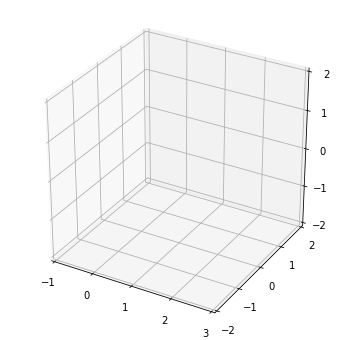

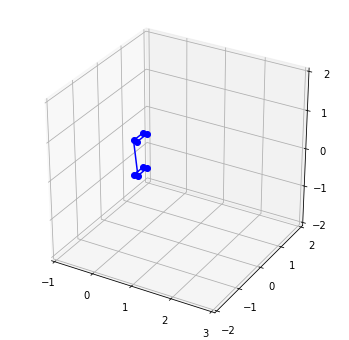

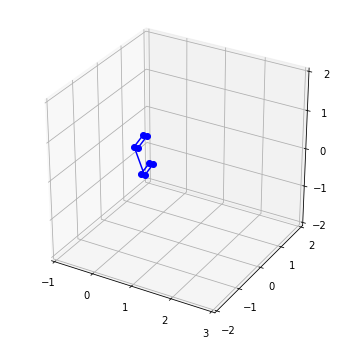

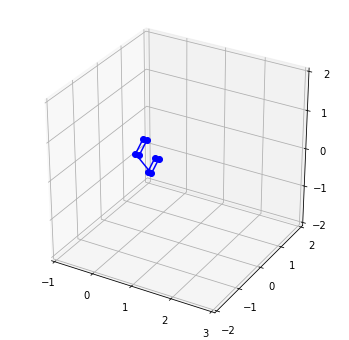

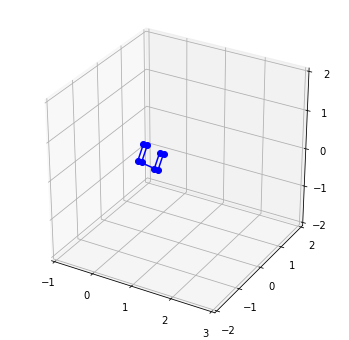

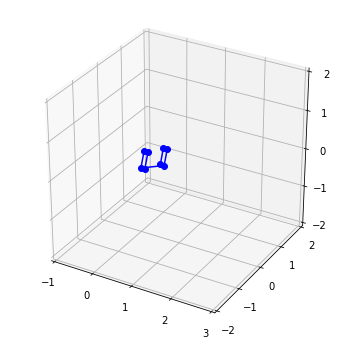

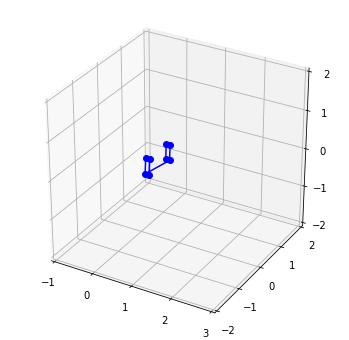

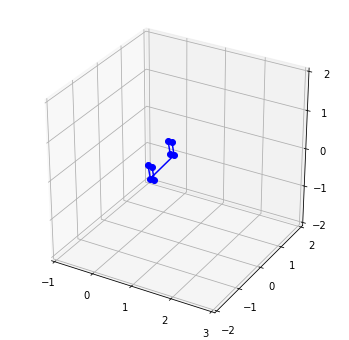

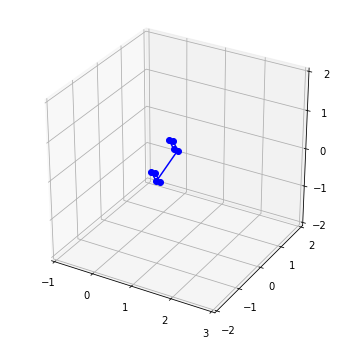

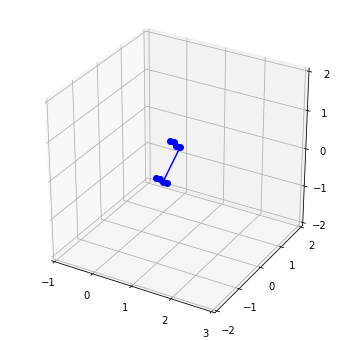

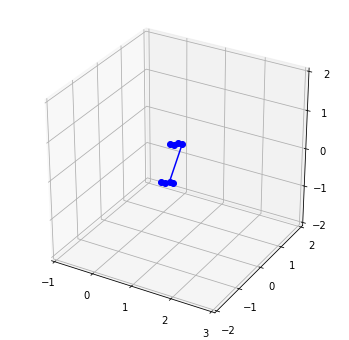

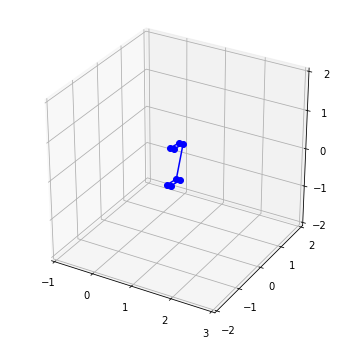

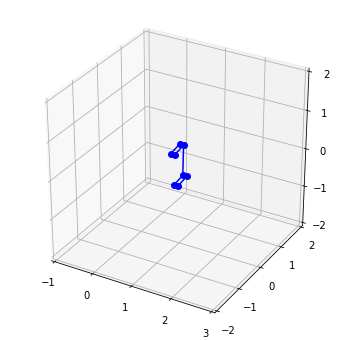

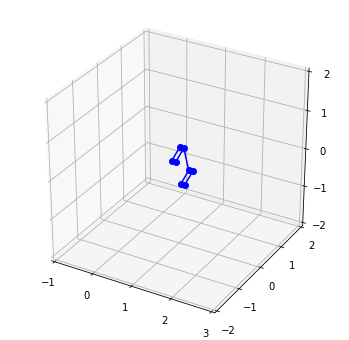

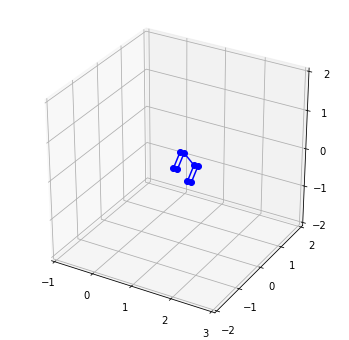

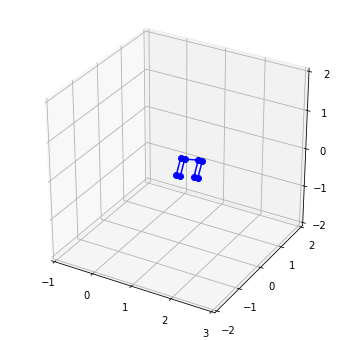

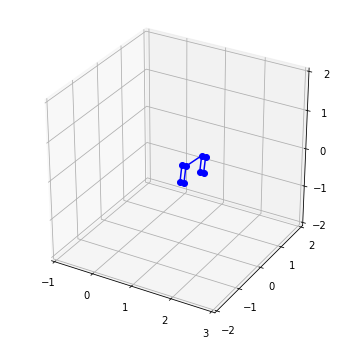

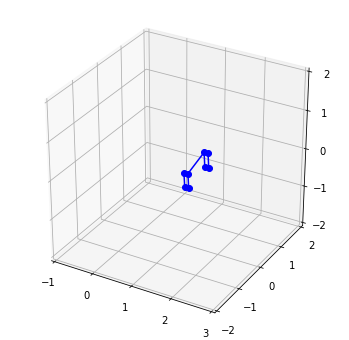

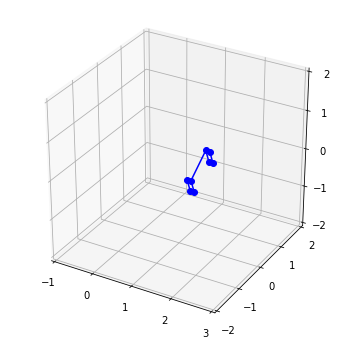

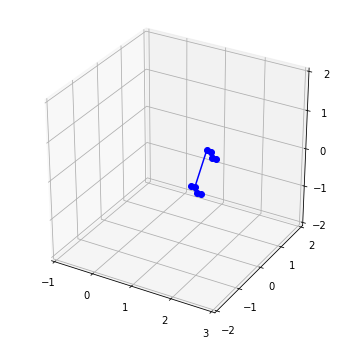

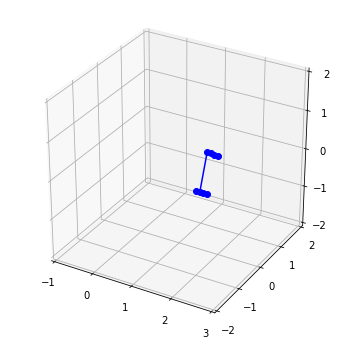

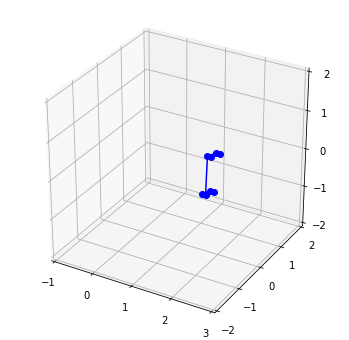

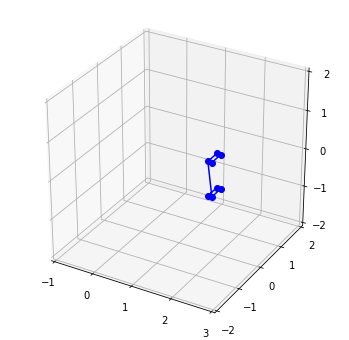

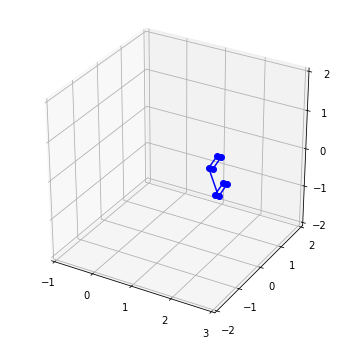

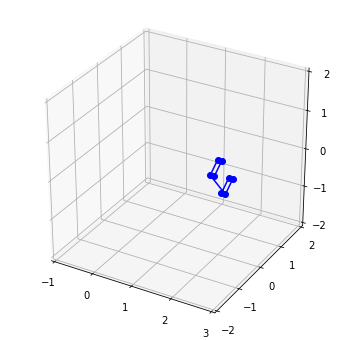

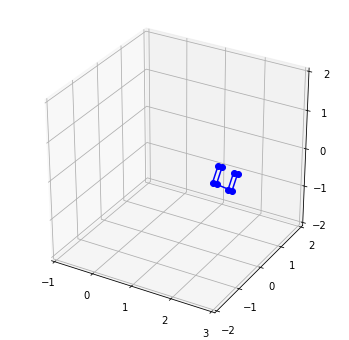

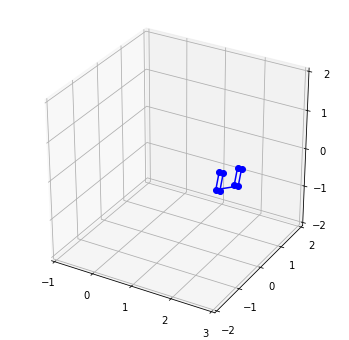

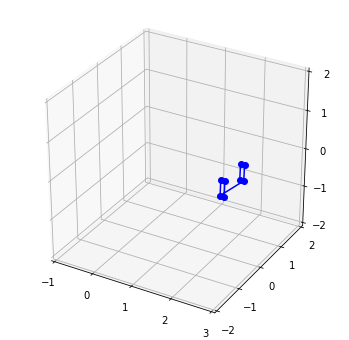

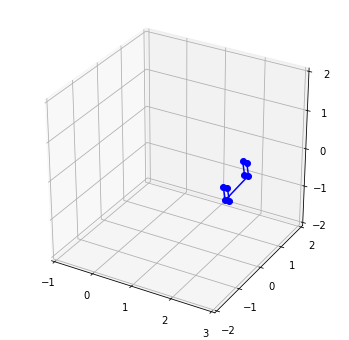

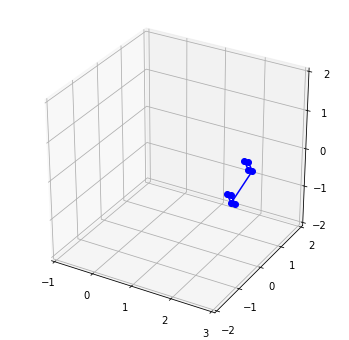

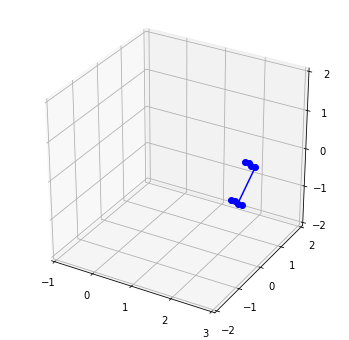

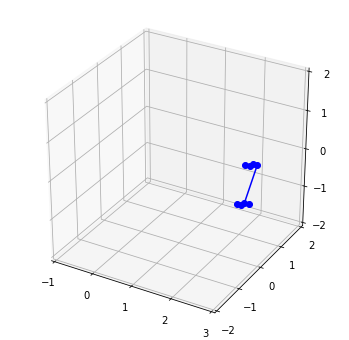

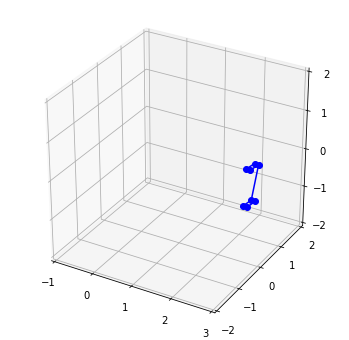

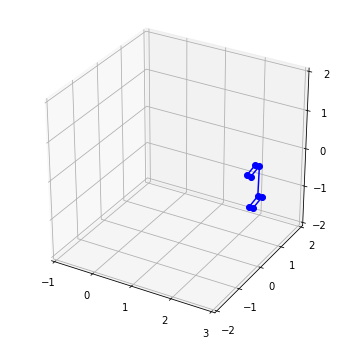

In [115]:
#inline
import numpy as np #行列計算のためnumpyをインポート
import math        #三角関数を使うためにmathをインポート
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

#global uLINK G
ToRad = math.pi/180;
G = 9.8;
BODY=1;
WAIST = 1;
R0=np.eye(3);
p0= [0,0,0];
mass = 10.0; 
AX=[-1.0, 3.]; AY=[-2., 2.]; AZ=[-2., 2.0];
ims=[];

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
ax.set_xticks(np.linspace(AX[0], AX[1], 5))
ax.set_yticks(np.linspace(AY[0], AY[1], 5))
ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))

arr = [0]*2
arr[0]=uLINK("empty",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,0) # 空のゼロリンクを設定（ワールド座標系）
arr[0].vertex=np.array([]);
# def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
arr[BODY]=uLINK("BODY",0,0,mass,0,[0, 0, 0],[0.0, 0.0, 1.0],0,R0,p0,0,0,0,0,0,0,0,0)

#uLINK = struct('name','BODY'    , 'm', 10, 'sister', 0, 'child', 0, 'b',[0  0  0]','a',[0 0 1]','q',0);
#uLINK.mother = 0;

#% Inertia tensor
lx  = 0.1;
ly  = 0.4;
lz  = 0.9;

#[uLINK(1).vertex,uLINK(1).face]   = MakeBox([lx ly lz]  ,[lx/2 ly/2 lz/2] );    % BODY
wdh=[lx, ly, lz];
arr[BODY].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])
print("arr.vertex1 ", arr[1].vertex);
for n in range(3): #原点移動
    for j in range(8):
        arr[BODY].vertex[j,n] = arr[BODY].vertex[j,n] - wdh[n]/2;
#print("arr.vertex2 ", arr[1].vertex);



#%% body state
#arr[WAIST]=uLINK("WAIST",0,0,mass,0,[0, 0, 0],[0.0, 0.0, 1.0],0,R0,p0,0,0,0,0,0,0,0,0)
#uLINK(WAIST).p = [0, 0, 0]';
#uLINK(WAIST).R = eye(3);
arr[WAIST].w = [1, 0, 0]; #uLINK(WAIST).w  = [1, 0, 0]';
arr[WAIST].vo = [0.3, 0, 0]; # uLINK(WAIST).vo = [0.3 0 1]';
#arr[WAIST].vertex=[];

for n in range(len(arr)):
    arr[n].u = 0.0;

Dtime = 0.3;
time  = 10.0;
tsize = int(time//Dtime); # length(time);「//」は商だけ求める演算子
print("tsize ",tsize)
for n in range(tsize):
    DrawAllJoints(1);
    [arr[WAIST].p, arr[WAIST].R] = SE3exp(1, Dtime);       


In [108]:
print("arr.vertex ", arr[0].vertex.any());

arr.vertex  False
